# Classification: Instant Recognition with Caffe

In this example we'll classify an image with the bundled CaffeNet model (which is based on the network architecture of Krizhevsky et al. for ImageNet).

We'll compare CPU and GPU modes and then dig into the model to inspect features and the output.

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* If needed, download the reference model ("CaffeNet", a variant of AlexNet).

In [3]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

...100%, 232 MB, 1453 KB/s, 163 seconds passed

### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [4]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [5]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


### 3. CPU classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

In [6]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

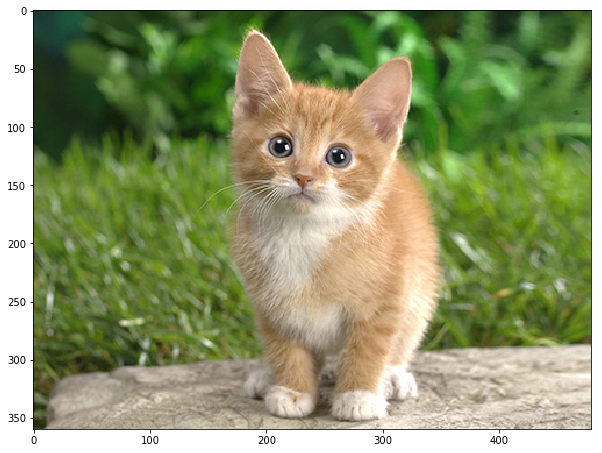

In [7]:
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

* Adorable! Let's classify it!

In [8]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 281


* The net gives us a vector of probabilities; the most probable class was the 281st one. But is that correct? Let's check the ImageNet labels...

In [9]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]

Downloading...
--2017-03-02 16:27:30--  http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz
Resolving dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)... 169.229.222.251
Connecting to dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)|169.229.222.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17858008 (17M) [application/octet-stream]
Saving to: ‘caffe_ilsvrc12.tar.gz’

caffe_ilsvrc12.tar. 100%[===================>]  17.03M  1.53MB/s    in 11s     

2017-03-02 16:27:42 (1.50 MB/s) - ‘caffe_ilsvrc12.tar.gz’ saved [17858008/17858008]

Unzipping...
Done.
output label: n02123045 tabby, tabby cat


* "Tabby cat" is correct! But let's also look at other top (but less confident predictions).

In [10]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.31244716, 'n02123045 tabby, tabby cat'),
 (0.23797037, 'n02123159 tiger cat'),
 (0.12387832, 'n02124075 Egyptian cat'),
 (0.10075204, 'n02119022 red fox, Vulpes vulpes'),
 (0.070957236, 'n02127052 lynx, catamount')]

* We see that less confident predictions are sensible.

### 4. Switching to GPU mode

* Let's see how long classification took, and compare it to GPU mode.

In [11]:
%timeit net.forward()

1 loop, best of 3: 1.42 s per loop


* That's a while, even for a batch of 50 images. Let's switch to GPU mode.

In [12]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
net.forward()  # run once before timing to set up memory
%timeit net.forward()

10 loops, best of 3: 70.2 ms per loop


* That should be much faster!

### 5. Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form `(batch_size, channel_dim, height, width)`.

    The activations are exposed as an `OrderedDict`, `net.blobs`.

In [11]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 227, 227)
conv1	(50, 96, 55, 55)
pool1	(50, 96, 27, 27)
norm1	(50, 96, 27, 27)
conv2	(50, 256, 27, 27)
pool2	(50, 256, 13, 13)
norm2	(50, 256, 13, 13)
conv3	(50, 384, 13, 13)
conv4	(50, 384, 13, 13)
conv5	(50, 256, 13, 13)
pool5	(50, 256, 6, 6)
fc6	(50, 4096)
fc7	(50, 4096)
fc8	(50, 1000)
prob	(50, 1000)


* Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.

    The param shapes typically have the form `(output_channels, input_channels, filter_height, filter_width)` (for the weights) and the 1-dimensional shape `(output_channels,)` (for the biases).

In [12]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


* Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

In [13]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

* First we'll look at the first layer filters, `conv1`

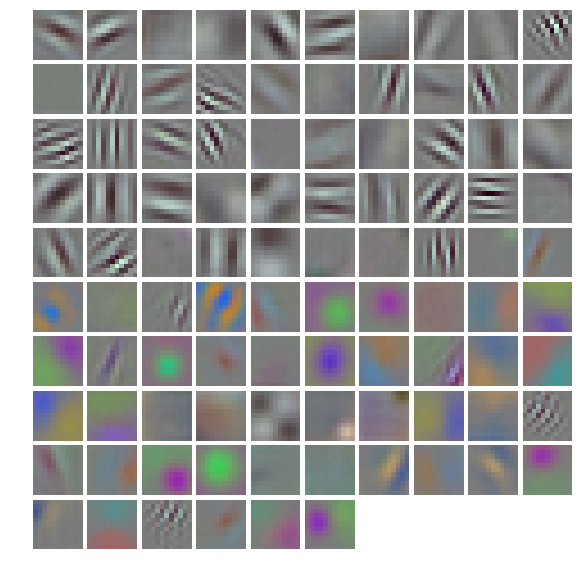

In [14]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

* The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

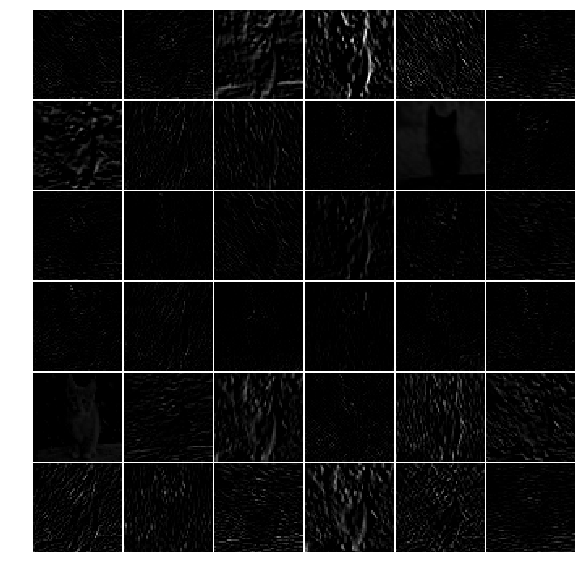

In [15]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat)

* The fifth layer after pooling, `pool5`

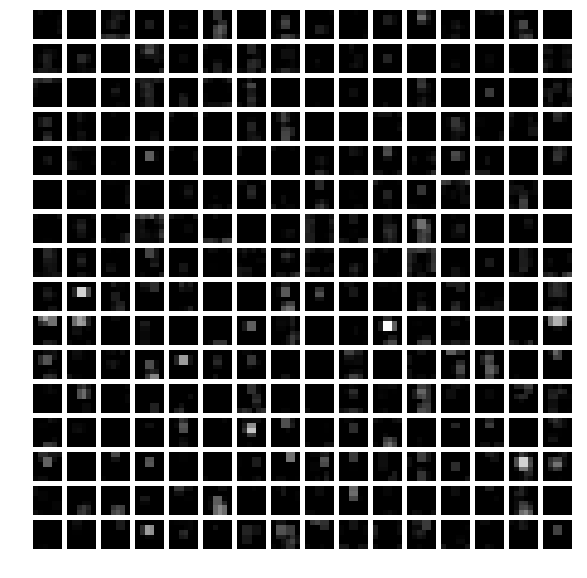

In [16]:
feat = net.blobs['pool5'].data[0]
vis_square(feat)

* The first fully connected layer, `fc6` (rectified)

    We show the output values and the histogram of the positive values

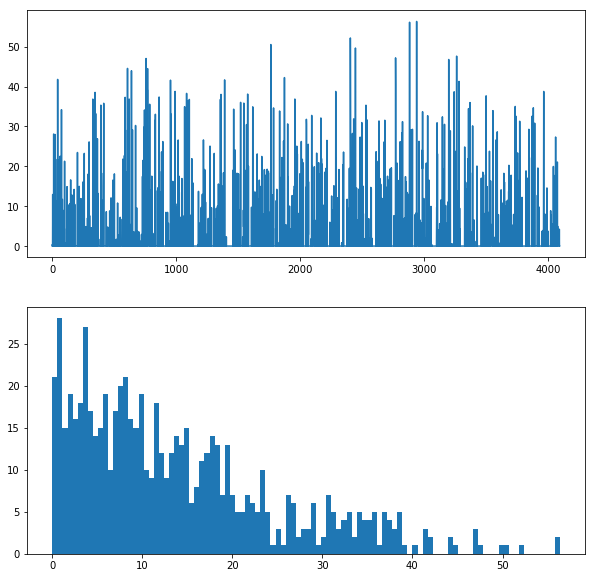

In [17]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

* The final probability output, `prob`

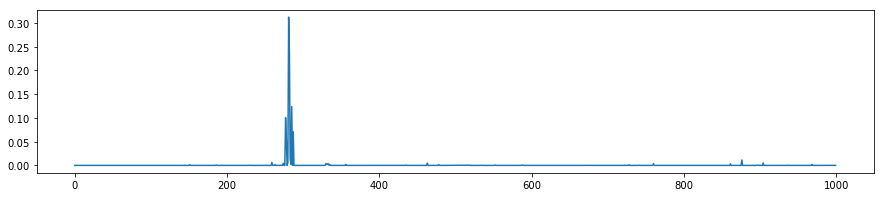

In [18]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

Note the cluster of strong predictions; the labels are sorted semantically. The top peaks correspond to the top predicted labels, as shown above.

### 6. Try your own image

Now we'll grab an image from the web and classify it using the steps above.

* Try setting `my_image_url` to any JPEG image URL.

--2017-03-02 16:52:26--  https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443340 (1.4M) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]   1.38M   422KB/s    in 3.5s    

2017-03-02 16:52:30 (407 KB/s) - ‘image.jpg’ saved [1443340/1443340]

probabilities and labels:


[(0.96841639, 'n02480495 orangutan, orang, orangutang, Pongo pygmaeus'),
 (0.030277491, 'n02492660 howler monkey, howler'),
 (0.00084077509, 'n02493509 titi, titi monkey'),
 (0.00014605187, 'n02493793 spider monkey, Ateles geoffroyi'),
 (7.3880219e-05, 'n02488291 langur')]

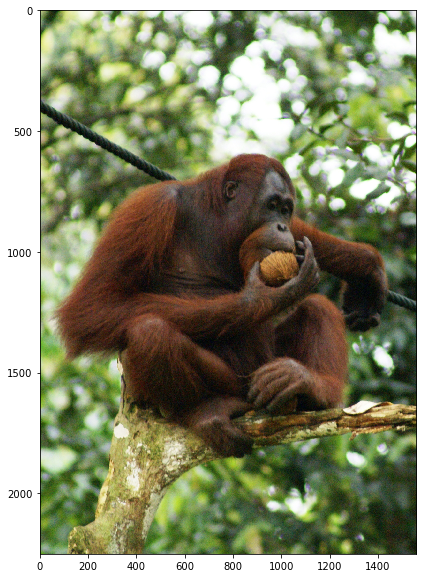

In [20]:
# download an image
my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

* Try an example of a lion.

--2017-03-02 17:00:33--  https://upload.wikimedia.org/wikipedia/commons/7/73/Lion_waiting_in_Namibia.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 314509 (307K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 307.14K   340KB/s    in 0.9s    

2017-03-02 17:00:34 (340 KB/s) - ‘image.jpg’ saved [314509/314509]

probabilities and labels:


[(0.9999851, 'n02129165 lion, king of beasts, Panthera leo'),
 (3.1352113e-06, 'n02397096 warthog'),
 (1.433798e-06, 'n02132136 brown bear, bruin, Ursus arctos'),
 (9.8088844e-07, 'n02117135 hyena, hyaena'),
 (9.5799351e-07, 'n02129604 tiger, Panthera tigris')]

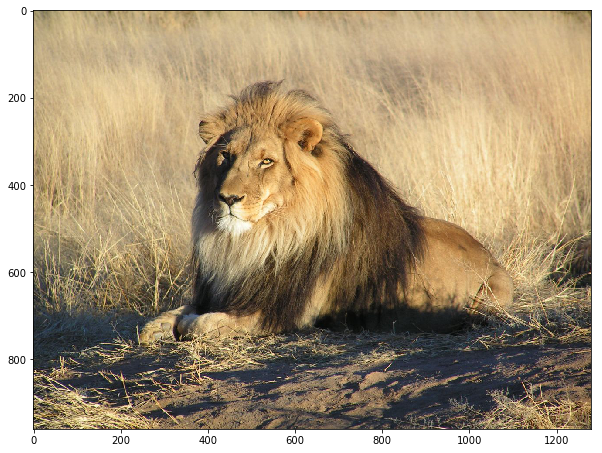

In [23]:
# download an image
my_image_url = "https://upload.wikimedia.org/wikipedia/commons/7/73/Lion_waiting_in_Namibia.jpg"  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

* Try an example of a leopard.

--2017-03-02 17:04:57--  https://upload.wikimedia.org/wikipedia/commons/0/0b/African_Leopard_5.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1798794 (1.7M) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]   1.71M   479KB/s    in 3.9s    

2017-03-02 17:05:01 (446 KB/s) - ‘image.jpg’ saved [1798794/1798794]

probabilities and labels:


[(0.6340518, 'n02128385 leopard, Panthera pardus'),
 (0.36409765, 'n02130308 cheetah, chetah, Acinonyx jubatus'),
 (0.0017246157, 'n02128925 jaguar, panther, Panthera onca, Felis onca'),
 (2.1563657e-05, 'n02128757 snow leopard, ounce, Panthera uncia'),
 (1.6454418e-05, 'n01692333 Gila monster, Heloderma suspectum')]

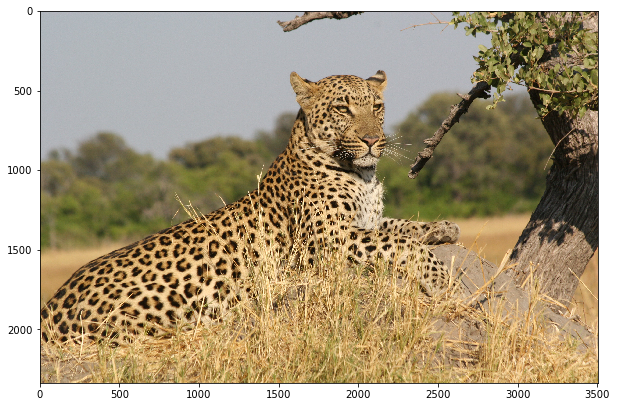

In [26]:
# download an image
my_image_url = "https://upload.wikimedia.org/wikipedia/commons/0/0b/African_Leopard_5.JPG"  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]
plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

* Try an example of a cheetah.

--2017-03-02 17:06:01--  http://weknowyourdreams.com/images/cheetah/cheetah-01.jpg
Resolving weknowyourdreams.com (weknowyourdreams.com)... 178.63.68.205
Connecting to weknowyourdreams.com (weknowyourdreams.com)|178.63.68.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137403 (134K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 134.18K  98.3KB/s    in 1.4s    

2017-03-02 17:06:04 (98.3 KB/s) - ‘image.jpg’ saved [137403/137403]

probabilities and labels:


[(0.98791933, 'n02130308 cheetah, chetah, Acinonyx jubatus'),
 (0.0066107078, 'n02128385 leopard, Panthera pardus'),
 (0.0043263133, 'n02128925 jaguar, panther, Panthera onca, Felis onca'),
 (0.0011375095, 'n02128757 snow leopard, ounce, Panthera uncia'),
 (1.6814192e-06, 'n02127052 lynx, catamount')]

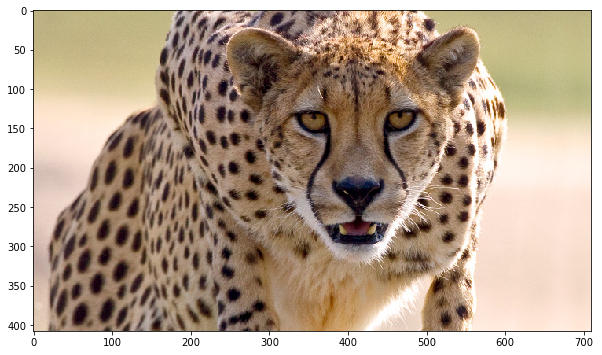

In [27]:
# download an image
my_image_url = "http://weknowyourdreams.com/images/cheetah/cheetah-01.jpg"  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]
plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

* Try an example of a tiger.

--2017-03-02 17:11:23--  http://weknowyourdreams.com/images/tiger/tiger-03.jpg
Resolving weknowyourdreams.com (weknowyourdreams.com)... 178.63.68.205
Connecting to weknowyourdreams.com (weknowyourdreams.com)|178.63.68.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 555091 (542K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 542.08K   155KB/s    in 3.5s    

2017-03-02 17:11:27 (155 KB/s) - ‘image.jpg’ saved [555091/555091]

probabilities and labels:


[(0.71507567, 'n02129604 tiger, Panthera tigris'),
 (0.28478271, 'n02123159 tiger cat'),
 (0.00012011497, 'n02128925 jaguar, panther, Panthera onca, Felis onca'),
 (1.5114802e-05, 'n02128385 leopard, Panthera pardus'),
 (4.4664616e-06, 'n02391049 zebra')]

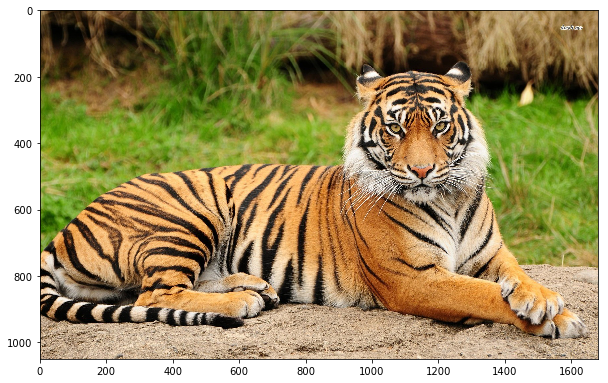

In [29]:
# download an image
my_image_url = "http://weknowyourdreams.com/images/tiger/tiger-03.jpg"  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]
plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

* Try an example of a bus.

--2017-03-02 17:14:57--  https://upload.wikimedia.org/wikipedia/ko/c/c2/%EC%9D%B8%EC%B2%9C_%EC%8B%9C%EB%82%B4%EB%B2%84%EC%8A%A4_721%EB%B2%88.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1079101 (1.0M) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]   1.03M   321KB/s    in 3.3s    

2017-03-02 17:15:01 (321 KB/s) - ‘image.jpg’ saved [1079101/1079101]

probabilities and labels:


[(0.86666387, 'n04487081 trolleybus, trolley coach, trackless trolley'),
 (0.10864902, 'n04335435 streetcar, tram, tramcar, trolley, trolley car'),
 (0.019996051, 'n03769881 minibus'),
 (0.0021458147, 'n02704792 amphibian, amphibious vehicle'),
 (0.001097279, 'n03895866 passenger car, coach, carriage')]

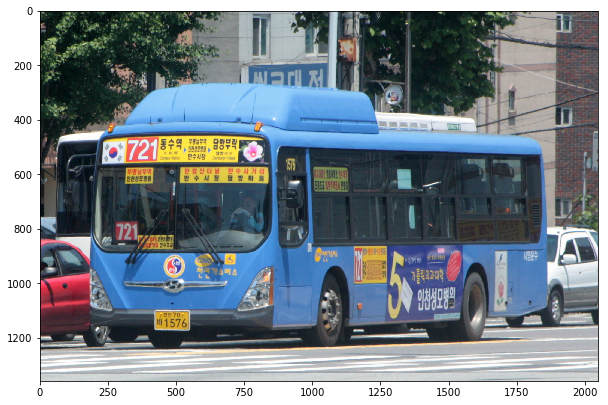

In [30]:
# download an image
my_image_url = "https://upload.wikimedia.org/wikipedia/ko/c/c2/%EC%9D%B8%EC%B2%9C_%EC%8B%9C%EB%82%B4%EB%B2%84%EC%8A%A4_721%EB%B2%88.JPG"  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]
plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

* Try an example of another bus.

--2017-03-02 17:18:40--  https://upload.wikimedia.org/wikipedia/ko/d/d6/%EC%9D%B8%EC%B2%9C%EC%8B%9C%EB%82%B4%EB%B2%84%EC%8A%A4_557%EB%B2%88.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1354488 (1.3M) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]   1.29M   349KB/s    in 4.1s    

2017-03-02 17:18:45 (322 KB/s) - ‘image.jpg’ saved [1354488/1354488]

probabilities and labels:


[(0.79855263, 'n04487081 trolleybus, trolley coach, trackless trolley'),
 (0.091896497, 'n04335435 streetcar, tram, tramcar, trolley, trolley car'),
 (0.086505793, 'n03769881 minibus'),
 (0.01379887,
  'n03977966 police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria'),
 (0.003478555, 'n02701002 ambulance')]

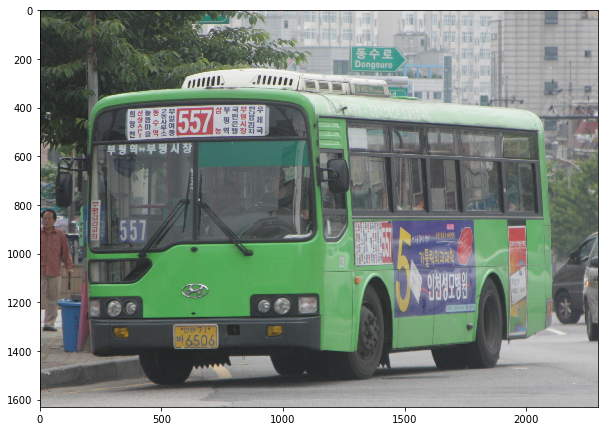

In [31]:
# download an image
my_image_url = "https://upload.wikimedia.org/wikipedia/ko/d/d6/%EC%9D%B8%EC%B2%9C%EC%8B%9C%EB%82%B4%EB%B2%84%EC%8A%A4_557%EB%B2%88.JPG"  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]
plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

* Try an example of a KTX train.

--2017-03-02 17:21:03--  https://upload.wikimedia.org/wikipedia/commons/c/c2/KTX-1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6003253 (5.7M) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]   5.72M   729KB/s    in 10s     

2017-03-02 17:21:14 (560 KB/s) - ‘image.jpg’ saved [6003253/6003253]

probabilities and labels:


[(0.46601793, 'n03272562 electric locomotive'),
 (0.40660298, 'n02917067 bullet train, bullet'),
 (0.12421095, 'n03895866 passenger car, coach, carriage'),
 (0.0017738739, 'n04335435 streetcar, tram, tramcar, trolley, trolley car'),
 (0.0013300941, 'n03393912 freight car')]

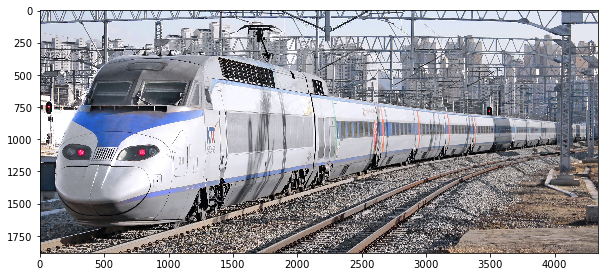

In [32]:
# download an image
my_image_url = "https://upload.wikimedia.org/wikipedia/commons/c/c2/KTX-1.jpg"  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]
plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

* Try an example of a steam locomotive.

--2017-03-02 17:23:57--  http://cfile237.uf.daum.net/image/2144844053492F370E5DF4
Resolving cfile237.uf.daum.net (cfile237.uf.daum.net)... 114.108.157.208
Connecting to cfile237.uf.daum.net (cfile237.uf.daum.net)|114.108.157.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75824 (74K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  74.05K  --.-KB/s    in 0.06s   

2017-03-02 17:23:57 (1.26 MB/s) - ‘image.jpg’ saved [75824/75824]

probabilities and labels:


[(0.99998665, 'n04310018 steam locomotive'),
 (1.1513654e-05,
  'n04389033 tank, army tank, armored combat vehicle, armoured combat vehicle'),
 (5.0180773e-07, 'n04428191 thresher, thrasher, threshing machine'),
 (3.5035302e-07, 'n02704792 amphibian, amphibious vehicle'),
 (3.3274395e-07, 'n02950826 cannon')]

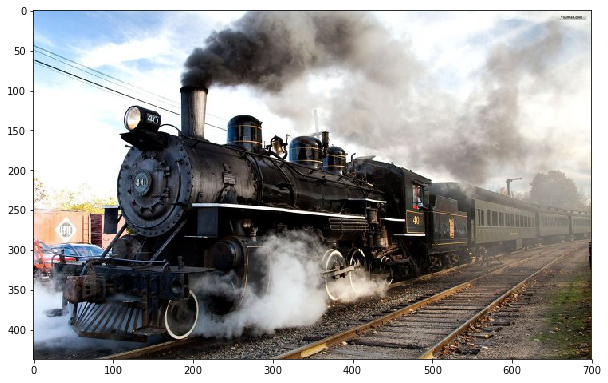

In [33]:
# download an image
my_image_url = "http://cfile237.uf.daum.net/image/2144844053492F370E5DF4"  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]
plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

* Try an example of a steam locomotive without steam.

--2017-03-02 17:25:24--  http://cfile201.uf.daum.net/image/115C014B507F3BBA172035
Resolving cfile201.uf.daum.net (cfile201.uf.daum.net)... 114.108.157.201
Connecting to cfile201.uf.daum.net (cfile201.uf.daum.net)|114.108.157.201|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136159 (133K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 132.97K   718KB/s    in 0.2s    

2017-03-02 17:25:24 (718 KB/s) - ‘image.jpg’ saved [136159/136159]

probabilities and labels:


[(0.99814522, 'n04310018 steam locomotive'),
 (0.00083347381, 'n02950826 cannon'),
 (0.00015675793,
  'n04389033 tank, army tank, armored combat vehicle, armoured combat vehicle'),
 (0.00014419337, 'n04428191 thresher, thrasher, threshing machine'),
 (0.00013725241, 'n04008634 projectile, missile')]

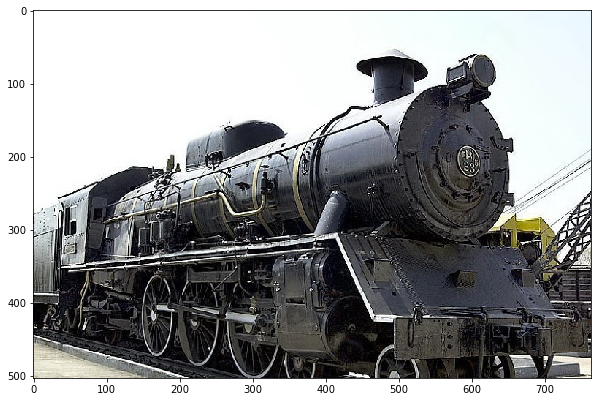

In [34]:
# download an image
my_image_url = "http://cfile201.uf.daum.net/image/115C014B507F3BBA172035"  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]
plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])